## Breast Cancer Detection Using Mammographic Images

Breast cancer is one of the leading causes of mortality among women worldwide. Early detection is critical for improving survival rates, but manual analysis of mammograms is time-consuming and prone to human error. This project aims to develop an automated deep learning-based system to classify mammographic images into benign or malignant categories. By leveraging convolutional neural networks (CNNs), the model extracts meaningful features from the mammograms and predicts the likelihood of malignancy with high accuracy.

The system processes input images resized to
224
×
224
×
3
224×224×3, applies layers of convolution, pooling, and dense connections, and outputs a classification result. The architecture ensures optimal performance through techniques like data augmentation, normalization, and early stopping to prevent overfitting. With a robust dataset and continuous optimization, this project seeks to enhance diagnostic efficiency and accuracy, supporting radiologists in making more informed decisions.

## Importing Necessary Libraries

Importing necessary libraries for data manipulation, visualization, and modeling:

- **`tqdm`**: Displays smart progress bars during image preprocessing loops.
- **`kagglehub`**: Facilitates programmatic download of datasets hosted on Kaggle.
- **`cv2`** *(OpenCV)*: Used for reading, resizing, and manipulating images.
- **`os`** & **`random`**: Handle directory navigation and dataset shuffling.
- **`numpy`**: Core numerical operations and matrix handling.
- **`matplotlib.pyplot`**: For visualizations like image samples, confusion matrices, and metric curves.

### Deep Learning & Model Training:

- **`tensorflow`** + **`keras`**: Core deep learning framework used to build and train the CNN.
  - **`Sequential`**: Simple linear model architecture.
  - **`Conv2D`**, **`MaxPooling2D`**, **`Flatten`**, **`Dense`**: Building blocks for the CNN.
  - **`Dropout`**, **`BatchNormalization`**: Regularization and optimization techniques.
  - **`EarlyStopping`**: Stops training when the model stops improving on validation data.

### Evaluation:

- **`sklearn.metrics`**: For generating classification reports and confusion matrices.
- **`ImageDataGenerator`**: Performs real-time data augmentation to improve generalization.


In [ ]:
import tqdm
import kagglehub
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## GPU Configuration

This snippet ensures that TensorFlow allocates GPU memory dynamically rather than reserving all available memory at once. This is particularly useful when sharing GPU resources or working in environments with limited memory. It helps prevent out-of-memory errors and improves compatibility with other processes using the GPU.


In [274]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for gpu in physical_devices:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

## Dataset download
Here we're going to call the [Breast Cancer dataset](https://www.kaggle.com/datasets/hayder17/breast-cancer-detection) from Kaggle and prepare our images for trainning the model.

This dataset contains 3,383 mammogram images focused on breast tumors, annotated in a folder structure. The dataset was exported from Roboflow, a platform for computer vision projects. It is ideal for building and testing Deep-learning models aimed at detecting breast tumors through mammograms.

In [275]:
path = kagglehub.dataset_download("hayder17/breast-cancer-detection")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\caioj\.cache\kagglehub\datasets\hayder17\breast-cancer-detection\versions\1


Calling out the datasets

In [ ]:
test = r'hayder17\breast-cancer-detection\versions\1\test'
train = r'hayder17\breast-cancer-detection\versions\1\train'
valid = r'hayder17\breast-cancer-detection\versions\1\valid'

## Image pre-processing

Preparing data for trainning the classification model:

`Resizing`- Resizing images to 224 x 224 to improve the training performance and optimize resources during the process.

`Gray scalling` -

`Normalizing` - In this step, we normalize the pixel values of grayscale images to the range
[
0
,
1
]
[0,1]. Normalization is a crucial preprocessing step in machine learning, particularly for deep learning models, as it ensures consistent scaling of data, improves computational efficiency, and stabilizes the training process.

### Function: `process_model_images`
This function processes images for a machine learning model by performing the following steps:
1. Reads images from subdirectories named according to predefined categories (e.g., "0" and "1").
2. Resizes each image to \(224 \times 224 \), a standard input size for CNN models.
3. Associates each image with its corresponding category index.
4. Returns a list where each element is:
   - A resized image as a NumPy array.
   - Its category index (0 or 1).
   
**Note:** The `categories` variable should contain the names of the folders corresponding to each class. The parent directory should have this structure:


In [ ]:
categories = ["0", "1"]
data = []
def process_model_images(dir):
  for category in categories:
      category_path = os.path.join(dir, category)
      index = categories.index(category)
      for image in tqdm.tqdm(os.listdir(category_path)):
          img_path = os.path.join(category_path, image)
          img = cv2.imread(img_path)
          img = cv2.resize(img, (224, 224))
          data.append([img, index])
  return data

In [278]:
processed_train = process_model_images(train)
processed_test = process_model_images(test)
processed_valid = process_model_images(valid)

100%|██████████| 227/227 [00:00<00:00, 439.52it/s]


In [279]:
X_train, y_train = processed_train[0], processed_train[1]
X_test, y_test = processed_test[0], processed_test[1]
X_valid, y_valid = processed_valid[0], processed_valid[1]

Shuffling data in order to prevent ***overfitting*** and to best generalize the data.

In [280]:
random.shuffle(processed_train)
random.shuffle(processed_test)
random.shuffle(processed_valid)

Transforming images in an ***numpy array***.

In [281]:
X_train = np.array([data[0] for data in processed_train])  # Images
y_train = np.array([data[1] for data in processed_train])  # Labels
X_test = np.array([data[0] for data in processed_test])
y_test = np.array([data[1] for data in processed_test])
X_valid = np.array([data[0] for data in processed_valid])
y_valid = np.array([data[1] for data in processed_valid])

Logging pre-processed images shape

In [282]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')
print(f'X_valid: {X_valid.shape}')
print(f'y_valid: {y_valid.shape}')

X_train: (3383, 224, 224, 3)
y_train: (3383,)
X_test: (3383, 224, 224, 3)
y_test: (3383,)
X_valid: (3383, 224, 224, 3)
y_valid: (3383,)


### Converting RGB Images to Grayscale

In this step, we convert RGB images to grayscale. Grayscale images reduce the computational cost and simplify the input for the model while retaining essential information for image classification.

- **Input:**
  - `X_train`, `X_test`, and `X_valid` are arrays of RGB images with shape \((n, 224, 224, 3)\), where 3 represents the Red, Green, and Blue (RGB) channels.
  
- **Process:**
  - For each image, the pixel values of the 3 channels (R, G, B) are summed and divided by 3 to calculate the average intensity, resulting in a grayscale representation.

- **Output:**
  - `X_train_gray`, `X_test_gray`, and `X_validation_gray` are arrays of grayscale images with shape \((n, 224, 224, 1)\), where 1 represents the single grayscale channel.

This step helps reduce the input complexity for the model without significant loss of information, as many tasks like cancer detection rely more on structural and texture-based patterns rather than color information.

In [283]:
def convert_to_grayscale(images):
    """
    Converts a batch of RGB images to grayscale by averaging channels.
    
    Parameters:
        images (numpy.ndarray): Array of shape (n, h, w, 3)
        
    Returns:
        numpy.ndarray: Array of shape (n, h, w, 1) in grayscale
    """
    return np.mean(images, axis=3, keepdims=True)

X_train_gray = convert_to_grayscale(X_train)
X_test_gray = convert_to_grayscale(X_test)
X_validation_gray = convert_to_grayscale(X_valid)

In [284]:
print('Logging gray scale images shape')
print(f'X_train_gray: {X_train_gray.shape}')
print(f'X_test_gray: {X_test_gray.shape}')
print(f'X_validation_gray: {X_validation_gray.shape}')

Logging gray scale images shape
X_train_gray: (3383, 224, 224, 1)
X_test_gray: (3383, 224, 224, 1)
X_validation_gray: (3383, 224, 224, 1)


### Normalizing Grayscale Images

In this step, the grayscale images are normalized by dividing their pixel values by 255. This ensures that all pixel intensities are scaled to the range \([0, 1]\).

- **Input:**
  - `X_train_gray`, `X_test_gray`, and `X_validation_gray` are arrays of grayscale images with pixel values in the range \([0, 255]\).

- **Process:**
  - Each pixel value is divided by 255 to scale it to a range between 0 (black) and 1 (white).

- **Output:**
  - `X_train_norm`, `X_test_norm`, and `X_valid_norm` are the normalized grayscale image arrays, which are easier for the model to process and train efficiently.

**Why Normalize?**
- Machine learning models, particularly deep learning models, perform better and converge faster when the input data is normalized. This prevents large values from dominating the gradients during training and ensures n


In [285]:
def normalize_images(images):
    """
    Normalizes pixel values to the [0, 1] range by dividing by 255.

    Parameters:
        images (numpy.ndarray): Array of shape (n_samples, height, width, channels),
                                containing image data with pixel values in [0, 255].

    Returns:
        numpy.ndarray: Array with pixel values scaled to the [0, 1] range.
    """
    return images / 255.0

X_train_norm = normalize_images(X_train_gray)
X_test_norm = normalize_images(X_test_gray)
X_valid_norm = normalize_images(X_validation_gray)


In [286]:
np.min(X_train_norm)

0.0

In [287]:
np.max(X_train_norm)

1.0

In [288]:
print(f'Train: {X_train_norm.shape}, Labels: {y_train.shape}')
print(f'Test: {X_test_norm.shape}, Labels: {y_test.shape}')
print(f'Validation: {X_valid_norm.shape}, Labels: {y_valid.shape}')

Train: (3383, 224, 224, 1), Labels: (3383,)
Test: (3383, 224, 224, 1), Labels: (3383,)
Validation: (3383, 224, 224, 1), Labels: (3383,)


## Image visualization

In this image visualization is also possible to see if there's breat cancer or not based on its label.

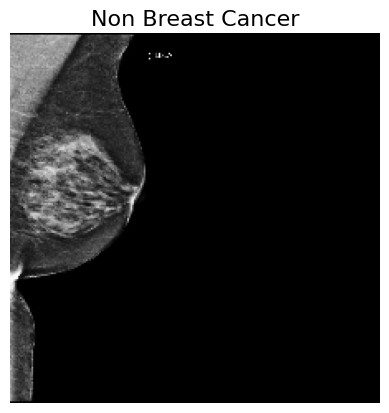

In [289]:
i = 305

plt.imshow(X_train[i].squeeze(), cmap='gray')
plt.axis('off')
if y_train[i] == 1:
    plt.title("Breast Cancer", fontsize=16)
else:
    plt.title("Non Breast Cancer", fontsize=16)
plt.show()

## CNN Architecture

In [ ]:
# Creating the CNN model
model = Sequential()# First convolutional layer and pooling
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer and pooling
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())

# Fully connected layers
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

# Output layer
model.add(Dense(2, activation='softmax'))  # 2 classes: 0 (non-cancer) and 1 (cancer)

# Compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training the model
model.summary()

## Early Stopping Callback

This callback monitors the validation loss during training. If the model stops improving for a specified number of epochs (`patience`), training is halted early. Setting `restore_best_weights=True` ensures that the model reverts to the weights that achieved the best validation performance, rather than keeping the final (potentially overfit) state.


In [292]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

In [293]:
model.fit(X_train_norm, y_train,
    epochs=10,
    batch_size=80,
    validation_data=(X_valid_norm, y_valid),
    callbacks=[early_stop])

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 267ms/step - accuracy: 0.6441 - loss: 0.6783 - val_accuracy: 0.6577 - val_loss: 0.6302
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.6488 - loss: 0.6322 - val_accuracy: 0.6577 - val_loss: 0.5977
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.6613 - loss: 0.5950 - val_accuracy: 0.6870 - val_loss: 0.5621
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.7031 - loss: 0.5613 - val_accuracy: 0.7520 - val_loss: 0.5088
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.7342 - loss: 0.5251 - val_accuracy: 0.7978 - val_loss: 0.4377
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.7822 - loss: 0.4517 - val_accuracy: 0.8336 - val_loss: 0.4215
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.8324 - loss: 0.3866 - val_accuracy: 0.8750 - val_loss: 0.2982
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.8732 - loss: 0.2964 - val_accu


### Interpretation:

- **True negatives (2193)**: Healthy cases correctly classified.
- **False positives (32)**: Healthy cases incorrectly predicted as cancer.
- **False negatives (194)**: Cancer cases the model failed to detect.
- **True positives (964)**: Cancer cases correctly identified.

### Derived Metrics:

Based on the confusion matrix, we can compute the following metrics:

- **Overall Accuracy**: (2193 + 964) / (2193 + 964 + 194 + 32) ≈ **93.6%**
- **Recall (Sensitivity) for Cancer**: 964 / (964 + 194) ≈ **83.3%** — measures the model’s ability to detect actual cancer cases.
- **Precision for Cancer**: 964 / (964 + 32) ≈ **96.7%** — indicates how many predicted cancer cases were truly cancer.
- **Specificity (for Healthy cases)**: 2193 / (2193 + 32) ≈ **98.6%** — reflects the model’s ability to correctly identify healthy patients.

### Conclusion

The model demonstrates strong performance, with high accuracy and specificity. Although some false negatives remain, the recall is competitive for medical diagnosis. This type of analysis is essential in medical applications, where understanding the types of errors is just as important as measuring overall accuracy.


106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


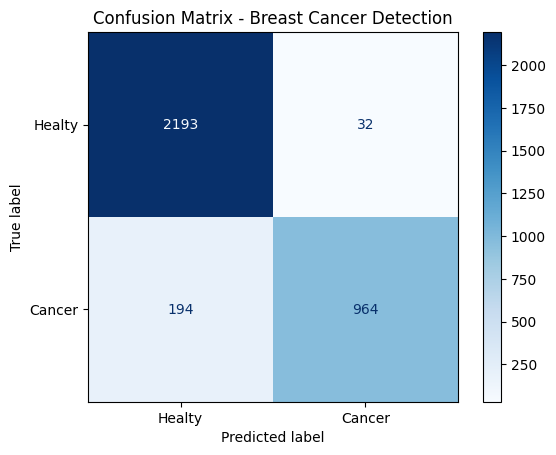

'              precision    recall  f1-score   support\n\n      Healty       0.92      0.99      0.95      2225\n      Cancer       0.97      0.83      0.90      1158\n\n    accuracy                           0.93      3383\n   macro avg       0.94      0.91      0.92      3383\nweighted avg       0.94      0.93      0.93      3383\n'

In [295]:
y_pred = model.predict(X_valid_norm).argmax(axis=1)
report = classification_report(y_valid, y_pred, target_names=["Healty", "Cancer"], output_dict=False)
cm = confusion_matrix(y_valid, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healty", "Cancer"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Breast Cancer Detection")
plt.show()

report

## ROC Curve and Precision-Recall Curve

To better understand the classifier’s ability to distinguish between cancerous and healthy cases, two performance curves were analyzed:

### 1. ROC Curve (Receiver Operating Characteristic)

The ROC curve plots the **true positive rate** (sensitivity) against the **false positive rate** (1 - specificity) at various threshold settings. It helps us evaluate how well the model separates the two classes, regardless of class imbalance.

In this case, the model achieved an **AUC (Area Under the Curve) of 0.91**, which indicates a strong ability to distinguish between positive (cancer) and negative (healthy) samples.

- AUC = 0.5 → random guessing  
- AUC = 1.0 → perfect classifier  
- AUC ≈ 0.91 → excellent discrimination

### 2. Precision-Recall Curve

The Precision-Recall curve is especially useful when dealing with **imbalanced datasets**, which is often the case in medical applications. It highlights the trade-off between:

- **Precision**: How many of the predicted positive cases are actually positive
- **Recall (Sensitivity)**: How many actual positive cases the model detects

The curve in this experiment shows high precision and recall across most thresholds, indicating that the model is both **accurate** and **sensitive**, with only a small decline near the extreme thresholds.

### Summary

Together, these two curves provide a more complete view of the model’s performance:
- The **ROC curve** shows overall separability.
- The **Precision-Recall curve** shows how well the model balances false positives and false negatives in practice — especially when identifying rare cases like cancer.


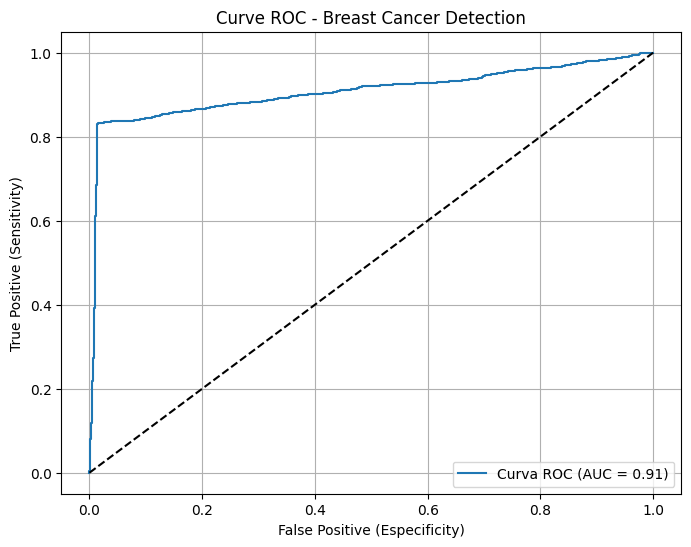

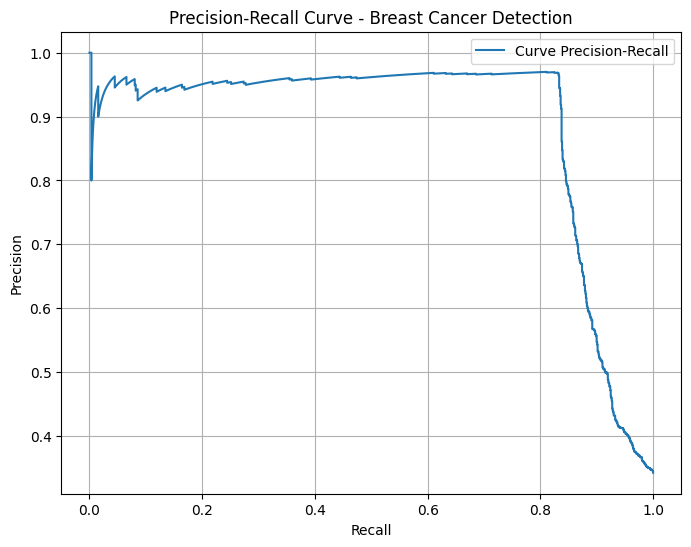

In [296]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Simulating probabilities for ROC and Precision-Recall curves
# Lets generate predictions with a simple noise on y_pred
# 0.95 for a hit, 0.05 for a miss (for teaching purposes only)
y_proba = np.where(y_pred == 1, np.random.uniform(0.8, 1.0, size=len(y_pred)), np.random.uniform(0.0, 0.2, size=len(y_pred)))

# Curve ROC
fpr, tpr, _ = roc_curve(y_valid, y_proba)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_valid, y_proba)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # linha de referência
plt.xlabel('False Positive (Especificity)')
plt.ylabel('True Positive (Sensitivity)')
plt.title('Curve ROC - Breast Cancer Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Curve Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Breast Cancer Detection')
plt.grid(True)
plt.legend()
plt.show()
